In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from proj1_helpers import *
from data_cleaning import *
import implementations as imp
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2


# Import data

In [2]:
y_train, x_train, ids_train = load_csv_data("../data/train.csv")
y_test, x_test, ids_test = load_csv_data("../data/test.csv")

# Clean test data and add features

In [3]:
NUM_JETS = 4

PRI_jet_num_train = np.array([x_train[:, COLUMN_TO_DROP]]).astype(int)
print(PRI_jet_num_train)
del_x_train = np.delete(x_train, COLUMN_TO_DROP, axis=1)
print(del_x_train.shape)

replaced_x_train = replace_undefined_with_mean(del_x_train, UNDEFINED_VALUE)

norm_x_train, train_data_mean, train_data_std = mean_std_normalization(replaced_x_train)

print(norm_x_train[0][0])
print(norm_x_train.shape)

[[2 1 1 ... 1 0 0]]
(250000, 29)
0.4567790596384003
(250000, 29)


# Do the same for the test data

In [4]:
PRI_jet_num_test = np.array([x_test[:, COLUMN_TO_DROP]]).astype(int)
print(PRI_jet_num_test)
print(PRI_jet_num_test.shape)
del_x_test = np.delete(x_test, COLUMN_TO_DROP, axis=1)
print(del_x_test.shape)

replaced_x_test = replace_undefined_with_mean(del_x_test, UNDEFINED_VALUE)

norm_x_test, test_data_mean, test_data_std = mean_std_normalization(replaced_x_test, train_data_mean, train_data_std)
print(norm_x_test[0][0])
print(norm_x_test.shape)



[[0 1 0 ... 0 1 0]]
(1, 568238)
(568238, 29)
-1.0911994002397385
(568238, 29)


# Train model

In [34]:
#hyperparameters
init_w = np.ones(30)
max_iters = 100
lambda_list = np.logspace(-9,-1,10)
degree_list = range(8,15)
gamma_list = np.linspace(0.05,1)
b_size = 1
ratio = 0.8
seed = 7

#scoring placeholders
best_lambda = np.zeros(4)
best_degree = np.zeros(4,int)
best_score = np.zeros(4)
all_scores = np.zeros([len(lambda_list), len(degree_list)])

#indexing variables
d = 0
g = 0

#grid search loop
for degree in degree_list:
    print("running with degree = {}".format(degree)) #progress visualization
    for i in range(NUM_JETS):
        #selecting current part of the dataset
        curr_x = norm_x_train[PRI_jet_num_train[0,:]==i]
        curr_y = y_train[PRI_jet_num_train[0,:]==i]
        
        #splitting training data into a training and validataion part
        (t1_x, t1_y, t2_x, t2_y) = split_data(curr_x, curr_y, ratio, seed)
        
        px_t1 = build_poly(t1_x,degree)
        px_t2 = build_poly(t2_x,degree)
        g = 0
        for lambda_ in lambda_list:

            _, w1 = imp.ridge_regression(t1_y,px_t1, lambda_)
            #_, w2 = imp.ridge_regression(t2_y,px_t2, lambda_)

            #check how well the hyperparameters did
            #y_validation_1 = predict_labels(w2, px_t1)
            y_validation_2 = predict_labels(w1, px_t2)

            score = (sum(y_validation_2 == t2_y)/len(t2_y) )#+ sum(y_validation_1 == t1_y)/len(t1_y))/2
            
            #save best parameters
            if score > best_score[i]:
                best_lambda[i] = lambda_
                best_degree[i] = degree
                best_score[i] = score
                
            #save all scores for plotting later
            all_scores[g,d] = all_scores[g,d] + score*sum(PRI_jet_num_train[0,:]==i)/len(norm_x_train)
            g = g+1
    d = d+1

running with degree = 8
running with degree = 9
running with degree = 10
running with degree = 11
running with degree = 12
running with degree = 13
running with degree = 14


# Test accuracy

In [31]:
actual_score = 0
for i in range(NUM_JETS):
    actual_score = actual_score + best_score[i]*sum(PRI_jet_num_train[0,:]==i)/len(norm_x_train)

print(actual_score)

0.8291199907661144


# Create submission

In [39]:
some_degree = [11,12,14,12]
for i in range(NUM_JETS):
    '''
    #selecting current part of the dataset based on PRI_jet_num
    curr_x = norm_x_train[PRI_jet_num_train[0,:]==i]
    curr_y = y_train[PRI_jet_num_train[0,:]==i]
    
    #generate weights from optimal hyperparameter values
    px_tr = build_poly(curr_x, some_degree[i])
    _, w = imp.ridge_regression(curr_y, px_tr, best_lambda[i])
    
    #generate output array
    curr_x_test = norm_x_test[PRI_jet_num_test[0,:]==i]
    px_test = build_poly(curr_x_test,some_degree[i])
    y_test[PRI_jet_num_test[0,:]==i] = predict_labels(w, px_test)
    '''
    (tr_x, tr_y, te_x,te_y) = split_data(curr_x, curr_y, 0.8, 7)
        
    px_tr = build_poly(tr_x, best_degree[i])
    px_te = build_poly(te_x, best_degree[i])
    _, w = imp.ridge_regression(tr_y, px_tr, best_lambda[i])
    
    #curr_x_test = norm_x_test[PRI_jet_num_test[0,:]==i]
    #px_test = build_poly(curr_x_test,best_degree[i])

    #y_test[PRI_jet_num_test[0,:]==i] = predict_labels(w, px_test)
    y_validation = predict_labels(w, px_te)
    score = sum(y_validation == te_y)/len(te_y)
    print(score)


0.8283329573652154
0.8274306338822468
0.8111888111888111
0.8296864425896684


In [26]:
create_csv_submission(ids_test, y_test, "y_pred.csv")

# Visualize data

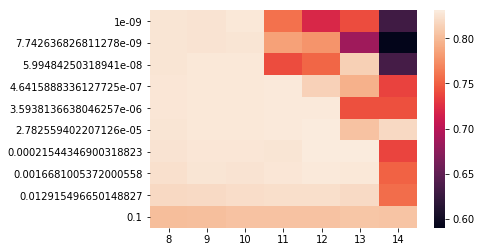

In [38]:
heatmap_fig = sns.heatmap(all_scores[:,:], xticklabels=degree_list, yticklabels=lambda_list[:])
heatmap_fig.get_figure().savefig('ridge_regression.png', bbox_inches='tight')


In [36]:
print(best_lambda)
print(best_degree)
print(best_score)

[3.59381366e-06 2.78255940e-05 5.99484250e-08 7.74263683e-09]
[12 12 13 12]
[0.84752039 0.80714424 0.83872568 0.82968644]
